# <center>Report of practical part of Assignment 2</center>
# <center>IFT6135-H19</center>

This file is used to generate the report for problem1-5 of practical part of assignment2.

Key codes are also included in this file. To review the whole codes for each problem, please turn to:

- models.py: implementation of RNN, GRU, TRANSFORMER for problem1-3; methods for generating sequences by RNN and GRU are also implemented in this file
- problem4.ipynb: codes for problem4
- problem5.ipynb codes for problem5
- helpers.py: including methods originally in ptb-lm.py, like `ptb_iterator`, etc.

in: https://github.com/qqiang00/IFT6135/blob/master/hw2/


**Team member**: 
- Qiang Ye (20139927)
- Ying Xiao (20111402)
- Boumaza Amel (20126028)
- Yunhe Li (20137167)

In [ ]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)
# change to your own directory
os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw2/")
#!ls -al
from IPython.display import Image

## Problem 1-3

For Problems 1-3, paste the code for the RNN, GRU, and Multi-Head attention rspectively in your report, in a monospace font.

### Problem 1

We built an internal class `RNN_Unit` manipulating tensor for layer over times. The whole implementation for `RNN` is as follows:
```python
class RNN(nn.Module): # Implement a stacked vanilla RNN with Tanh nonlinearities.

  class RNN_Unit(nn.Module):
    def __init__(self, input_size, hidden_size):
      super(RNN.RNN_Unit, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def init_weights(self, k = None):
        if k is None:
            k = 1. / math.sqrt(self.hidden_size)

        nn.init.uniform_(self.i2h.weight, -1 * k, k)
        nn.init.uniform_(self.i2h.bias, -1 * k, k)

    def forward(self, input):
      return torch.tanh(self.i2h(input))


  def __init__(self, emb_size, hidden_size, seq_len, batch_size, vocab_size, 
               num_layers, dp_keep_prob):
    """
    emb_size:     The numvwe of units in the input embeddings
    hidden_size:  The number of hidden units per layer
    seq_len:      The length of the input sequences
    vocab_size:   The number of tokens in the vocabulary (10,000 for Penn TreeBank)
    num_layers:   The depth of the stack (i.e. the number of hidden layers at 
                  each time-step)
    dp_keep_prob: The probability of *not* dropping out units in the 
                  non-recurrent connections.
                  Do not apply dropout on recurrent connections.
    """
    super(RNN, self).__init__()

    self.emb_size = emb_size
    self.hidden_size = hidden_size
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.num_layers = num_layers
    self.dp_keep_prob = dp_keep_prob
    self.i2e = nn.Embedding(vocab_size, emb_size) 
    self.h2o = nn.Linear(hidden_size, vocab_size)

    self.rnn_units = nn.ModuleList([])
    self.dropout = nn.Dropout(1 - dp_keep_prob)
    for i in range(num_layers):
      input_size = emb_size if i == 0 else hidden_size
      self.rnn_units.append(RNN.RNN_Unit(input_size, hidden_size))

    self.init_weights() # need this to initialize weights?
    return 

  def init_weights(self):
    # Initialize the embedding and output weights uniformly in the range [-0.1, 0.1]
    # and the embedding and output biases to 0 (in place).
    # Initialize all other (i.e. recurrent and linear) weights AND biases uniformly 
    # in the range [-k, k] where k is the square root of 1/hidden_size
    nn.init.uniform_(self.i2e.weight, -0.1, 0.1)
    nn.init.uniform_(self.h2o.weight, -0.1, 0.1)
    nn.init.zeros_(self.h2o.bias)
    k = 1. / math.sqrt(self.hidden_size)
    for i in range(self.num_layers):
      self.rnn_units[i].init_weights(k)
      
  def init_hidden(self):
    # initialize the hidden states to zero
    """
    This is used for the first mini-batch in an epoch, only.
    """
    hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
    return hidden.requires_grad_()
    # a parameter tensor of shape (self.num_layers, self.batch_size, self.hidden_size)

  def forward(self, inputs, hidden):
    # Compute the forward pass, using nested python for loops.
    # The outer for loop should iterate over timesteps, and the 
    # inner for loop should iterate over hidden layers of the stack. 
    # 
    # Within these for loops, use the parameter tensors and/or nn.modules you 
    # created in __init__ to compute the recurrent updates according to the 
    # equations provided in the .tex of the assignment.
    #
    # Note that those equations are for a single hidden-layer RNN, not a stacked
    # RNN. For a stacked RNN, the hidden states of the l-th layer are used as 
    # inputs to to the {l+1}-st layer (taking the place of the input sequence).

    """
    Arguments:
        - inputs: A mini-batch of input sequences, composed of integers that 
                    represent the index of the current token(s) in the vocabulary.
                        shape: (seq_len, batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)
    
    Returns:
        - Logits for the softmax over output tokens at every time-step.
              **Do NOT apply softmax to the outputs!**
              Pytorch's CrossEntropyLoss function (applied in ptb-lm.py) does 
              this computation implicitly.
                    shape: (seq_len, batch_size, vocab_size)
        - The final hidden states for every layer of the stacked RNN.
              These will be used as the initial hidden states for all the 
              mini-batches in an epoch, except for the first, where the return 
              value of self.init_hidden will be used.
              See the repackage_hiddens function in ptb-lm.py for more details, 
              if you are curious.
                    shape: (num_layers, batch_size, hidden_size)
    """
    seq_len = inputs.size(0) # (seq_len, batch_size)
    outputs_seqs = [] # list of output for each word in seq
    for i in range(seq_len):# iterate over seq
        embedded = self.dropout(self.i2e(inputs[i,:])) # (batch_size, emb_size)
        #print("embedded.shape:", embedded.shape)
        # size of each recurrent hidden layer output is (batch_size, hidden_size)
        output_cur_layer = None
        hs = [] # hidden states of each recurrent layer
        for j in range(self.num_layers): # more than 1 recurrent hidden layer
            input_cur_layer = embedded if j == 0 else output_cur_layer # 
            combined = torch.cat((input_cur_layer, hidden[j,:,:]), 1)
            hidden_cur_layer = self.rnn_units[j](combined) 
            output_cur_layer = self.dropout(hidden_cur_layer)
            hs.append(torch.unsqueeze(hidden_cur_layer, 0))
        
        output_cur_layer = self.h2o(output_cur_layer)
        hidden = torch.cat(hs, 0) # new hidden for next word in seq
        outputs_seqs.append(torch.unsqueeze(output_cur_layer, 0))
    
    logits = torch.cat(outputs_seqs, 0)
    return logits.view(self.seq_len, self.batch_size, self.vocab_size), hidden
```

### Problem 2

Like what we did for problem 1, we also built an `GRU_Unit` to flow the tensors one layer over times. We re-used almost all the other codes in RNN, except we replaced `RNN_Unit` with `GRU_Unit` when creating instances of `GRU_Unit`. For simplicity, we here only pasted the implementation of `GRU_Unit`. For the whole implementation of `GRU`, refer to the file `models.py`.

```python
class GRU(nn.Module): # Implement a stacked GRU RNN
  """
  Follow the same instructions as for RNN (above), but use the equations for 
  GRU, not Vanilla RNN.
  """
  class GRU_Unit(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU.GRU_Unit, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.i2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2z = nn.Linear(input_size + hidden_size, hidden_size)
        self.ir2hd = nn.Linear(input_size + hidden_size, hidden_size) 
      
    def init_weights(self, k = None):
        if k is None:
            k = 1. /math.sqrt(self.hidden_size)
        nn.init.uniform_(self.i2r.weight, -k, k)
        nn.init.uniform_(self.i2r.bias, -k, k)
        nn.init.uniform_(self.i2z.weight, -k, k)
        nn.init.uniform_(self.i2z.bias, -k, k)
        nn.init.uniform_(self.ir2hd.weight, -k, k)
        nn.init.uniform_(self.ir2hd.bias, -k, k)

    def forward(self, input):
        """input (batch_size, input_size+hidden_size)""" 
        x_size = self.input_size # real input size
        xt = input[:, :x_size] # (batch_size, x_size)
        ht = input[:, x_size:] # old ht (h_{t-1}) (batch_size, output_size)
        rt = torch.sigmoid(self.i2r(input)) # (batch_size, output_size)
        zt = torch.sigmoid(self.i2z(input)) # (batch_size, output_size)
        hd = torch.cat((xt, torch.mul(rt, ht)), 1) # (batch_size, input_size)
        hd = torch.tanh(self.ir2hd(hd)) # h_t^{tilde} (batch_size, input_size)
        ht_part1 = torch.mul(torch.sub(1, zt), ht)
        ht_part2 = torch.mul(zt, hd)
        ht = torch.add(ht_part1, ht_part2) # new ht (h_{t})
        return ht
    
  # please refer to "models.py" for whole implementation of the whole GRU class.
```


### Problem 3

The following codes are our implementation of `MultiHeadAttention` for `TRANSFORMER`:

```python
class MultiHeadedAttention(nn.Module):
    # Based on: https://github.com/harvardnlp/annotated-transformer

    def __init__(self, n_heads, n_units, dropout=0.1):
        """
        n_heads: the number of attention heads
        n_units: the number of output units
        dropout: probability of DROPPING units
        """
        super(MultiHeadedAttention, self).__init__()
        # This sets the size of the keys, values, and queries (self.d_k) to all 
        # be equal to the number of output units divided by the number of heads.
        self.d_k = n_units // n_heads
        # This requires the number of n_heads to evenly divide n_units.
        assert n_units % n_heads == 0
        self.n_units = n_units # hidden_size

        # Initialize all weights and biases uniformly in the range [-k, k],
        # where k is the square root of 1/n_units.
        # Note: the only Pytorch modules you are allowed to use are nn.Linear 
        # and nn.Dropout
        self.n_heads = n_heads
        self.linears = clones(nn.Linear(n_units, n_units), 4)
        k = 1. / math.sqrt(self.n_units)
        for linear in self.linears:
            nn.init.uniform_(linear.weight, -1*k, k)
            nn.init.uniform_(linear.bias, -1*k, k)

        self.dropout = nn.Dropout(dropout)

        
    def forward(self, query, key, value, mask=None):
        # implement the masked multi-head attention.
        # query, key, and value all have size: (batch_size, seq_len, self.n_units)
        # mask has size: (batch_size, seq_len, seq_len)
        # As described in the .tex, apply input masking to the softmax 
        # generating the "attention values" (i.e. A_i in the .tex)
        # Also apply dropout to the attention values.
        batch_size = query.size(0)
        Qi, Ki, Vi = [l(x).view(
            batch_size, -1, self.n_heads, self.d_k).transpose(1, 2) 
            for l, x in zip(self.linears, (query, key, value))]
        d_k = Qi.size(-1) # d_k = self.d_k
        scores = torch.matmul(Qi, Ki.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        
        Ai = torch.softmax(scores, dim = -1)
        Ai = self.dropout(Ai) # reasonable? dropout an probability?
        Hi = torch.matmul(Ai, Vi)
        Hi = Hi.transpose(1, 2).contiguous().view(batch_size, -1, 
                                                  self.n_heads * self.d_k)
        A = self.linears[-1](Hi)
        return A # A shape: (batch_size, seq_len, self.n_units)
    ```


## Problem 4

refer to problem4.ipynb for codes and results for problem4 

## Problem5

For problem5, we need to load training and validationg dataset, and to load pre-trained models. 

These codes are as follows:
(Note: only key codes and results are listed for better understanding the report. Please refer to the file "problem5.py" for full implementation)

#### Load training and validation dataset

Use method `ptb_raw_data` to load training valid and test data for further use.

In [1]:
import argparse
import torch 
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from models import WordEmbedding, PositionalEncoding
from models import RNN, GRU
from models import make_model as TRANSFORMER

import os
import collections
import matplotlib.pyplot as plt
from helpers import ptb_raw_data, ptb_iterator, repackage_hidden, Batch

In [2]:
####################### Setup Experiment ##########################
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage")
    device = torch.device("cpu")


data_path = "data"
# LOAD DATA
print('loading data from ' + data_path + "...")
raw_data = ptb_raw_data(data_path = data_path)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('  vocabulary size: {}'.format(vocab_size))
print(len(train_data), len(valid_data))

Using the GPU
loading data from data...
  vocabulary size: 10000
929589 73760


#### Load pre-trained models from file saved by problem4.1
We wrote the following methods to load configurations and pre-trained models, and then load the pre-trained models from question 4.1.

In [3]:
def read_config(filepath):
    """read config data from file to a dict
    """
    cfg = dict()
    with open (filepath, 'r') as f:
        for line in f.readlines():
            key, value = line.split()
            #print(key, value)
            cfg[key] = value

    return cfg


def model_from_cfg(cfg, vocab_size):
    model_name = cfg["model"]
    emb_size = int(cfg["emb_size"])
    hidden_size = int(cfg["hidden_size"])
    seq_len = int(cfg["seq_len"])
    batch_size = int(cfg["batch_size"])
    #vocab_size = int(cfg["vocab_size"])
    num_layers = int(cfg["num_layers"])
    dp_keep_prob = float(cfg["dp_keep_prob"])

    if model_name == "RNN":
        return RNN(
            emb_size = emb_size, hidden_size = hidden_size, seq_len = seq_len,
            batch_size = batch_size, vocab_size = vocab_size, num_layers = num_layers,
            dp_keep_prob = dp_keep_prob)
    elif model_name == "GRU":
        return GRU(
            emb_size = emb_size, hidden_size = hidden_size, seq_len = seq_len,
            batch_size = batch_size, vocab_size = vocab_size, num_layers = num_layers,
            dp_keep_prob = dp_keep_prob)
    elif model_name == "TRANSFORMER":
        model = TRANSFORMER(
            vocab_size = vocab_size, n_units = hidden_size,
            n_blocks = num_layers, dropout = 1.- dp_keep_prob)
        model.batch_size = batch_size
        model.seq_len = seq_len
        model.vocab_size = vocab_size
        return model
    else:
        print("Model type not recognized.")
        return None


def load_pretrained_model(model_dir, vocab_size = 10000):
    model = None
    cfg = read_config(os.path.join(model_dir,"exp_config.txt"))
    torch.manual_seed(int(cfg["seed"]))
    model = model_from_cfg(cfg, vocab_size = vocab_size)
    model.load_state_dict(torch.load(os.path.join(model_dir,"best_params.pt")))
    return model

In [5]:
# three dirs generated during training but with dir name changed
# we will use the config and trained weights data to load and analysis model
model_dirs = [ "RNN", "GRU", "TRANSFORMER"] #, "GRU", "TRANSFORMER"]
models = {}

for model_dir in model_dirs:
    model_name = model_dir 
    print("loading a pre-trained {} model...".format(model_name), end = " ")
    model = load_pretrained_model(model_dir, vocab_size = vocab_size)
    print("Done.")
    model.to(device)
    model.eval()
    models[model_name] = model 

loading a pre-trained RNN model... Done.
loading a pre-trained GRU model... Done.
loading a pre-trained TRANSFORMER model... Done.


### 5.1

Compute the average loss at each time-step (i.e. $L_t$ for each $t$) within validation sequences. Plot $L_t$ as a function of $t$, describe the result qualitatively, and provide an explanation for what you observe. Compare the plots for the different architectures.

   - For Problem 5.1, you can modify the loss computation in this script 
     (search for "LOSS COMPUTATION" to find the appropriate line. Remember to 
     submit your code.
     

After examing the method `ptb-iterator` and `run_epoch` in a given file `ptb-lm.py`, we have two options to do this problem:
- Option1: change seq_len to 1, feed data time-step by time-step with a certain `batch_size`, such that variable `loss` from the method `loss_fn` just gives loss for one time step. By averaging over the batch_size, we can finally obtain the average losses required.

  Note: we only need to initialize `hidden` once, at the very first time-step.
- Option2: keep seq_len with certan value (e.g. 35), modify the `loss_fn` by giving an attribute "reduction = 'non'" so that the loss are calculated per element in a tensor. Run the model for several steps each of which we feed data X ,y with the shape (batch_size, seq_len). The final loss can be obtained by averaging the sum of steps' losses with each also averaged by a `batch_size`. 

  Note: at the beginning of each step, `hidden` is re-initialized.


The follow codes is our implementation for Option2. Please refer to `problem5.py` for implementation of Option1 and other codes.


In [6]:
### for problem 5.1 
# Set the seq_len to 1, invocke the method `ptb_iterator` to generate training
# data with shape of (batch_size, 1) and then observe the losses 
def average_losses(model, model_name, data, max_time_step = None):
    loss_fn = nn.CrossEntropyLoss()
    losses = [] # hiddens along time step from 0 to model.seq_len-1
    
    if model_name != 'TRANSFORMER':
        hidden = model.init_hidden() # without reinitialize during loop
        hidden = hidden.to(device)
    
    for time_step, (x, y) in enumerate(ptb_iterator(data[37:], model.batch_size, model.seq_len)):
        # both x, y are of shape (batch_size, seq_len)
        if model_name == 'TRANSFORMER':
            batch = Batch(torch.from_numpy(x).long().to(device))
            model.eval()
            model.zero_grad()
            outputs = model.forward(batch.data, batch.mask).transpose(1,0)
        else:
            inputs = torch.from_numpy(x.astype(np.int64))
            inputs = inputs.transpose(0, 1).contiguous().to(device)#.cuda()
            model.eval()
            model.zero_grad()
            hidden = repackage_hidden(hidden)
            outputs, hidden = model(inputs, hidden)

        targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1)
        targets = targets.contiguous().to(device)#.cuda()
        tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))
        if tt.dim() == 0:
            tt = torch.unsqueeze(tt, 0)
        #print(outputs.contiguous().view(-1, model.vocab_size).shape)
        loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
        losses.append(loss.data.item())
        
        if (not max_time_step is None) and (time_step >= max_time_step - 1):
            return losses

    return losses

# here is another implementation without setting seq_len to 1.
# a little more complicated with memory comsuming.
# both work well with proper batch_size and seq_len
def average_losses2(model, model_name, data, max_time_step = None):
    
    loss_fn = nn.CrossEntropyLoss(reduction = "none") 
    # "none" means don't average or sum the losses, keep the shape
    
    losses = np.zeros(model.seq_len)
    model.eval()
    model.zero_grad()
    
    for time_step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, 
                                                    model.seq_len)):
        # both x, y are of shape (batch_size, seq_len)
        if model_name == 'TRANSFORMER':
            batch = Batch(torch.from_numpy(x).long().to(device))
            outputs = model.forward(batch.data, batch.mask).transpose(1,0)
        else:
            inputs = torch.from_numpy(x.astype(np.int64))
            inputs = inputs.transpose(0, 1).contiguous().to(device)#.cuda()
            hidden = model.init_hidden().to(device)#repackage_hidden(hidden)
            outputs, _ = model(inputs, hidden)

        targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1)
        targets = targets.contiguous().to(device)#.cuda()
        tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))
        
        outputs = outputs.contiguous().view(-1, model.vocab_size)
        # loss is a one-dimensional tensor here (seq_len * batch_size)
        loss = loss_fn(outputs, tt)       
        # converted to (seq_len, batch_size)
        loss = loss.view(model.seq_len, model.batch_size)
        # transpose loss shape to (batch_size, seq_len)
        loss = loss.cpu().data.numpy().transpose(1, 0) 
        #print(loss.shape)
        losses += np.mean(loss, axis = 0)
        
        # you may not want to calculate over the whole dataset
        if (not max_time_step is None) and (time_step >= max_time_step - 1):
            return losses
    
    losses = losses / time_step
    return losses

We use `average_losses2` to compute the losses

In [7]:
use_func = average_losses2 # you may change to use average_losses
losses = {} # for losses on three architectures

batch_size = 2048 if use_func is average_losses else 20
seq_len = 1 if use_func is average_losses else 70

print("######## Experiment 5.1 on valid_data #######")
for model_dir in model_dirs:
    model_name = model_dir
    model = models[model_name]
    model.seq_len = seq_len    
    model.batch_size = batch_size
    print("computing losses on {} for each time-step...".format(
        model_name), end = " ")
    losses[model_name] = use_func(model, model_name, valid_data)
    print("Done.")

######## Experiment 5.1 on valid_data #######
computing losses on RNN for each time-step... Done.
computing losses on GRU for each time-step... Done.
computing losses on TRANSFORMER for each time-step... Done.


Both methods derived similar results with slightly different performance for TRANSFORMER. We plotted them in the next 2 figures:



plotting losses of three models...
curve files saved in :figures/loss_curve_5.1_seq_len=70_batch_size=20.png


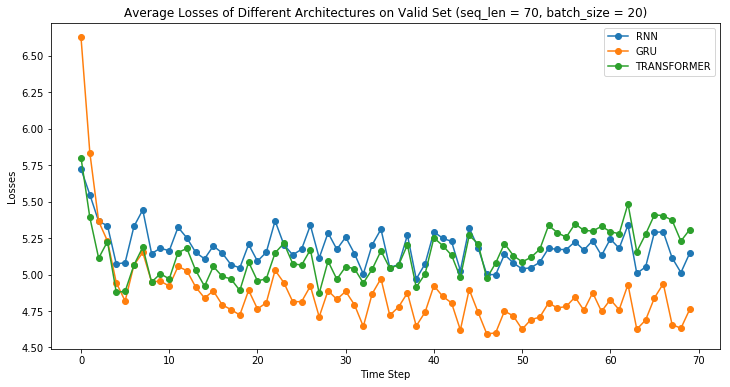

In [8]:
print("plotting losses of three models...")
len_losses = [len(losses[model_name]) for model_name in model_dirs]
min_len_losses = min(len_losses)

plt.figure(figsize = (12, 6))
time_steps = np.arange(min_len_losses)
for model_dir in model_dirs:
    plt.plot(time_steps, losses[model_dir][:min_len_losses], label = model_dir,
             marker = "o")

plt.xlabel('Time Step')
plt.ylabel('Losses')
plt.legend(loc='upper right')
fig_title = "Average Losses of Different Architectures on Valid Set"
fig_title += " (seq_len = {}, batch_size = {})".format(seq_len, batch_size)
plt.title(fig_title)

img_file = "figures/loss_curve_5.1_seq_len={}_batch_size={}.png".format(
            seq_len, batch_size) 
plt.savefig(img_file)
print("curve files saved in :{}".format(img_file))
plt.show()
#Image(filename='figures/5/loss_curve_5.1_seq_len=35_batch_size=20.png')

Our observation is:
1. for each architecture, losses start with a higher value then decrease quickly for next several time-steps, followed by a flat decreasing(not very obvious, sometimes with oscillations) trend as time flows.
2. Comparing the three architectures: GRU performs best, then TRANSFORMER, and RNN performs worst. But when using option2, TRANSFORMER is the worst, it may because of too short seq_len make TRANSFORMER have to predict without context. Nevertheless, as it is a pre-trained model, it still performs well.

Our explanation is as follows:
- **Higher loss at initial time step**: without any hidden information, models(RNN and GRU) tend to predict as trained, predicting words which are the starting words during training in steps with higher probabilities, If the starting words are much different in validation dataset( this is very normal, chang batch_size and sql_len will produce sequences with very different starting words). GRU having the highest Initial loss may just mean that the hidden status is more valuable for it, without usefull hidden information, GRU is just a little better than a random prediction(with average loss about 9.21).

- **Quick decreasing for first several time steps**: This is the effect of hidden units or context(for TRANSFORMER). with the help of context information, all models start to predict better and better. This is not the case when use `seq_len = 1` for TRANSFORMER, where it still has no context to use. It performs better than RNN `seq_len = 30` is used.

- **A long flat zone**: After a steep decreasing at the first several time steps, all architectures stuck into a flat zone, where the loss keeps a certain level. Loss value of 5 corresponds to a correct predicting probability of $e^{-5}= 0.0067 $ which is still 67 times higher than making a random prediction. Maybe it is because of the pattern diversities in the training dataset.

- **About the oscillations**: A sudden decreasing of loss may comes from a common pattern in the dataset, such as the <SOS> <EOS> <Ukn> tokens often come after or before certain words. But, we are not sure about this inference.

### 5.2 

For one minibatch of training data, compute the average gradient of the loss at the final
time-step with respect to the hidden state at each time-step $t$: $\nabla_{h_t} L_t$. The norm of these gradients can be used to evaluate the propagation of gradients; a rapidly decreasing norm means that longer-term dependencies have less influence on the training signal, and can indicate **vanishing gradients**. Plot the Euclidian norm of $\nabla_{h_t} L_t$ as a function of $t$ for each of the 3 architectures. Rescale the values of each curve to $[0,1]$ so that you can compare all three on one plot. Describe the results qualitatively, and provide an explanation for what you observe, discussing what the plots tell you about the gradient propagation in the different
architectures.

As we are only going to observe the gradients of GRU and RNN, we can set the `seq_len = 1` and run the model for several time steps.
By using the method `torch.autograd.grad`, we are able to get the loss at the final step  with respect to the hidden state at each time-step $t$. 

Our codes are as follows:

In [9]:
def average_gradients(model, model_name, data, max_time_step = 35):
    loss_fn = nn.CrossEntropyLoss()
    hiddens = [] # hiddens along time step from 0 to model.seq_len-1
    norm_gradients = []
    if model_name == 'TRANSFORMER':
        return None
    
    hidden = model.init_hidden()
    hidden = hidden.to(device)
    hiddens.append(hidden)
    model.train()
    model.zero_grad()
    
    for time_step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, 
                                                    model.seq_len)):
        # both x, y are of shape (batch_size, seq_len)
        inputs = torch.from_numpy(x.astype(np.int64)).transpose(0, 1)
        inputs = inputs.contiguous().to(device)#.cuda()
        outputs, hidden = model(inputs, hiddens[-1])
        hiddens.append(hidden)
        
        if time_step >= max_time_step - 1: # only seq_len time steps
            targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1)
            targets = targets.contiguous().to(device)#.cuda()
            tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))
            if tt.dim() == 0:
                tt = torch.unsqueeze(tt, 0)
            
            loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
            for i in range(len(hiddens)-2): # the last hidden doesn't require grade
                gradient = torch.autograd.grad(loss, hiddens[i], retain_graph = True)
                # gradient is a tuple (Tensor, )
                norm_gradients.append(torch.norm(gradient[0], p = 2).data.item())
            
            return norm_gradients

In [10]:
norm_grads = {}

print("######## Experiment 5.2 on one mini_batch of train_data #######")
for model_dir in model_dirs[0:2]: # TRANSFORMER excluded
    model_name = model_dir
    model = models[model_name]
    model.train()
    model.seq_len = 1 # one time step by one time step
    print("{}: computing gradients of hidden...".format(model_name), end = " ")
    norm_grad = np.array(average_gradients(model, model_name, train_data))
    # rescale to [0, 1]
    norm_grads[model_name] = norm_grad
    print("Done.")


######## Experiment 5.2 on one mini_batch of train_data #######
RNN: computing gradients of hidden... Done.
GRU: computing gradients of hidden... Done.


The result is as follows.

plotting average gradients of RNN and GRU models...
norm_grads plots saved in: figures/norm_grads_5.2_34.png


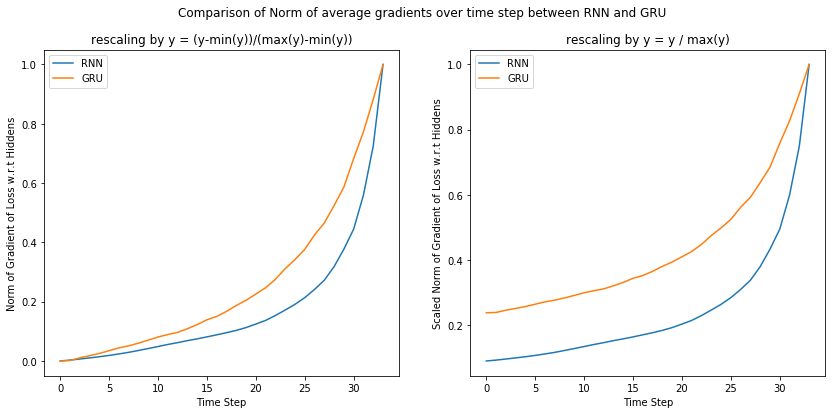

In [11]:
# analyze gradients and plot curves
print("plotting average gradients of RNN and GRU models...")
len_grads = [len(norm_grads[model_name]) for model_name in model_dirs[0:2]]
min_len_grads = min(len_grads)

time_steps = np.arange(min_len_grads)
def rescale(norm_grad):
    min_g, max_g = min(norm_grad), max(norm_grad)
    norm_grad = (norm_grad - min_g) / (max_g - min_g)
    return norm_grad
    
def rescale2(norm_grad):
    min_g, max_g = min(norm_grad), max(norm_grad)
    norm_grad = norm_grad / max_g
    return norm_grad
   
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
for model_dir in model_dirs[0:2]:
    plt.plot(time_steps, rescale(norm_grads[model_dir][:min_len_grads]), label = model_dir)
plt.xlabel('Time Step')
plt.ylabel('Norm of Gradient of Loss w.r.t Hiddens')
plt.legend(loc='upper left')
plt.title("rescaling by y = (y-min(y))/(max(y)-min(y))")
    
plt.subplot(1,2,2)
for model_dir in model_dirs[0:2]:
    plt.plot(time_steps, rescale2(norm_grads[model_dir][:min_len_grads]), label = model_dir)
plt.xlabel('Time Step')
plt.ylabel('Scaled Norm of Gradient of Loss w.r.t Hiddens')
plt.legend(loc='upper left')
plt.title("rescaling by y = y / max(y)")

plt.suptitle("Comparison of Norm of average gradients over time step between RNN and GRU")
    
img_file = "figures/norm_grads_5.2_" + str(min_len_grads) + ".png"
plt.savefig(img_file)
print("norm_grads plots saved in: {}".format(img_file))
plt.show()

Obvisouly, the figure shows that compared with the gradient of the final time-step, gradients of previous hiddens are getting smaller, which means gradient is vanishing or, we can say, not very easy to pass back through time. gradient of RNN decreased much faster than GRU, meaning that RNN only has short term memory, while GRU has longer, benefited from its gated recurrent unitits and hidden states.

### 5.3

Generate samples from both the Simple RNN and GRU, by recursively sampling $\hat{\mathbb x}_{t+1} \sim P(\mathbb x_{t+1} | \hat{\mathbb x}_1, \cdots \hat{\mathbb x}_t)$. Make sure to condition on the sampled $\hat{\mathbb x}_{t}$, not the ground truth. Produce 20 samples from both the RNN and GRU: 10 sequences of the same length as the training sequences, and 10 sequences of twice the length of the training sequences. Choose 3 “best”, 3 “worst”, and 3 that are “interesting”, and make reference to these to describe qualitatively the different models’ strengths, failure modes, quirks, and any potentially interesting things to investigate. Put all 40 samples in an appendix to your report.
  
   - For Problem 5.3, you must implement the generate method of the RNN and 
     GRU.  Implementing this method is not considered part of problems 1/2 
     respectively, and will be graded as part of Problem 5.3
     

For RNN and GRU class we implemented method `generate` to generate sequences. The codes are as follows:
```python
# the codes is considered a part of class RNN and GRU
def generate(self, input, hidden, generated_seq_len):
    # TODO ========================
    # Compute the forward pass, as in the self.forward method (above).
    # You'll probably want to copy substantial portions of that code here.
    # 
    # We "seed" the generation by providing the first inputs.
    # Subsequent inputs are generated by sampling from the output distribution, 
    # as described in the tex (Problem 5.3)
    # Unlike for self.forward, you WILL need to apply the softmax activation 
    # function here in order to compute the parameters of the categorical 
    # distributions to be sampled from at each time-step.

    """
    Arguments:
        - input: A mini-batch of input tokens (NOT sequences!)
                        shape: (batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)
        - generated_seq_len: The length of the sequence to generate.
                       Note that this can be different than the length used 
                       for training (self.seq_len)
    Returns:
        - Sampled sequences of tokens
                    shape: (generated_seq_len, batch_size)
    """
    samples = []
    predict = input # at time step 0, predict is input
    samples.append(torch.unsqueeze(predict, 0))
    for i in range(generated_seq_len): # each seq index
        # output is the predicted word index, with batch_size elements
        embedded = self.dropout(self.i2e(predict)) # (batch_size, emb_size)
        output_cur_layer = None
        hs = []
        for j in range(self.num_layers): # more than 1 recurrent hidden layer
            input_cur_layer = embedded if j == 0 else output_cur_layer # 
            combined = torch.cat((input_cur_layer, hidden[j,:,:]), 1)
            hidden_cur_layer = self.rnn_units[j](combined) #(batch_size, hidden_size)
            output_cur_layer = self.dropout(hidden_cur_layer)
            hs.append(torch.unsqueeze(hidden_cur_layer, 0))
            
        output_cur_layer = self.h2o(output_cur_layer)
        hidden = torch.cat(hs, 0) # new hidden for next word in seq
        p_output = torch.softmax(output_cur_layer, dim = -1) # (batch_size, vocab_size)
        predict = Categorical(p_output).sample().long() # batch_size
        # another option is just give the predict with largest probability
        # output_cur_layer = torch.argmax(output_cur_layer, dim = -1) # word_index
        samples.append(torch.unsqueeze(predict, 0))
    
    samples = torch.cat(samples, 0)
    return samples
```


Then, we implemented an method receiving a model and other parameters to generate `batch_size` sequences each with the length of `seq_len`

In [12]:
# for problem 5.3
def generate_seq(model, vocab_size = 10000):
    # generate sequence from a trained model
    model.eval()
    batch_size = model.batch_size
    seq_len = model.seq_len
    
    gen_hidden = torch.zeros(model.num_layers, batch_size, model.hidden_size)
    gen_hidden = gen_hidden.to(device)
    gen_hidden = repackage_hidden(gen_hidden)
    gen_input = torch.randint(0, vocab_size, (batch_size,)).contiguous()
    gen_input = gen_input.to(device)#.cuda()
    samples = model.generate(gen_input, gen_hidden, seq_len)
    # size of samples (seq_len, batch_size)
    samples = samples.transpose(0, 1).cpu().numpy()
    max_len = 80
    cur_len = 0
    for i in range(batch_size): # for each batch
        print("Seq {}: ".format(i), end = " ")
        cur_len = 7
        for j in range(seq_len):
            word = id_2_word[samples[i,j]]
            if cur_len + len(word) >= max_len:
                cur_len = 0
                print("")
            
            print(word, end = " ")
            cur_len += (len(word) + 1)
        print("\n")

Here is some best,worst, interesting sequences selected from what we generated.





The following codes are used to generate required sequences. We attached 40 required sequences as appendix. 

In [13]:
print("######## Experiment 5.3 on one mini_batch of train_data #######\n")
for model_dir in model_dirs[0:2]: # TRANSFORMER excluded
    model_name = model_dir
    model = models[model_name]
    model.eval()
    
    for seq_len in [35, 70]:
        model.batch_size = 10
        model.seq_len = seq_len
        print("{} sequences generated by model: {} with length {}\n".format(
            model.batch_size, model_name, model.seq_len))
        generate_seq(model)

######## Experiment 5.3 on one mini_batch of train_data #######

10 sequences generated by model: RNN with length 35

Seq 0:  unsecured accurate g.m.b buried working drill ceo ill. regularly 
disclosing downright crest achenbaum verge accelerate terminals ssangyong 
turmoil foes tokyu true sang viewers represented humor steadily importing wines 
novel parallel years request script revamping fueled 

Seq 1:  increases structures slack probing loyal improperly focused beautiful 
non-violent elephant emerged continually optical pressure upgrading earthquake 
politician trendy hectic exhausted from poughkeepsie disappointing signs 
house-passed upset added emotional christies omni sim bursts midst stanford 
failures 

Seq 2:  turkey mount $ fuels foundation ec orthodox notice beyond perceived 
eidsmo nickel prove beating distributing founded trucks beefeater criticisms 
development fledgling withdrew switzerland longtime reed octel maintenance 
retain understand salt illuminating stuart ex

mgm\/ua widely fight enabling publicity carolinas belief kansas tunnel aligned 
disappearance maker equivalent wealth popular although publishes plunge silicon 
singled judicial lunch microwave procter stimulate touch mink 

Seq 6:  thereafter accumulated marlowe fannie merck imposed alternative 
listening sheets reform sure dillon stays five missiles wooing mack placed 
centuries between kitchen rev. motor arafat comply gutfreund clinic persistent 
drawings toy save peat along bribery irresponsible 

Seq 7:  communists natwest upbeat borders trustee maturing practical trade bloc 
strengthened emotional prominent fastest-growing legitimate pet lumber verdict 
hands february pleased favored rocked watson free-lance industrywide equitec 
reveals marous dropped bork beatrice corning reductions cover dealings 

Seq 8:  applying apples wires mexican publicly spur woes economists smoothly 
proved mortality reinvested convey cell dinkins advantages sweet judging 
gallons mesa correct recommen